# Sampling with Space Partitioning

## Tutorial Notebook 

    Structure: 
    
    1. BAT model definition: Gaussian mixture
    2. Single-click run: Default settings  
    3. Detailed sampling summary
       -- @elapsed/@CPUelapsed time 
       -- Posterior integrals
       -- Plotting
    4. Fine-grained control: Samplers, integrators, partitioner 
       -- HMC/Sobol
    5. Kolmogorov–Smirnov tests
    
    --- 
    

In [1]:
# using Distributed 
# addprocs(3)

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using Revise
using BAT

## 1. BAT model definition: Gaussian mixture

Let us use a mixture of 4 normal distribution with random  covariance matrices as a model: 

In [4]:
σ_1 = [3.426818298733095 12.378238116671048 -9.632531611142454; 3.426818298733095 4.916266580684483 -5.029942800849483; 3.426818298733095 -6.737309268887753 5.4343957706004415; 3.426818298733095 -3.9729587574454333 3.379361860370276]
σ_2 = [12.378238116671048 69.83909693165143 -43.478993858310886; 4.916266580684482 69.83909693165143 -64.18784570966332; -6.737309268887753 69.83909693165143 32.734776615550174; -3.972958757445433 69.83909693165143 53.74871853095418]
σ_3 = [-9.632531611142456 -43.478993858310886 60.0626256206892; -5.029942800849484 -64.18784570966332 60.0626256206892; 5.4343957706004415 32.734776615550174 60.0626256206892; 3.3793618603702757 53.74871853095418 60.0626256206892]
σ = cat(σ_1,σ_2,σ_3, dims=3)

μ = [8.959570984309234 -9.021529871694005 -5.007789383392622; -1.446445514344754 -7.8327010768703875 -3.2653263028963986; -6.40954093270941 0.25815094665222027 5.830143596540282; 5.076504517881521 -0.8952973253675331 9.16356325348496]

mixture_model = MixtureModel(MvNormal[MvNormal(μ[i,:], Matrix(Hermitian(σ[i,:,:])) ) for i in 1:4]);


In [5]:
prior = NamedTupleDist(a = [Uniform(-50,50), Uniform(-50,50), Uniform(-50,50)])

likelihood = let model = mixture_model
    params -> begin
        return LogDVal(logpdf(model, params.a))
    end
end

posterior = PosteriorDensity(likelihood, prior);
log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

13.815510557964275

## 2. Single-click run: Default settings 

Default parameters of the `PartitionedSampling()` algorithm: 

1) Exploration samples: `MetropolisHastings()` sampler (20 chains * 10^2 samples)

2) Sampling: `MetropolisHastings()` sampler

3) Space partitioning: `KDTreePartitioning()`

4) Reweighting: `AHMIntegration()`


In [6]:
n_chains = 5 # chains per subspace 
n_samples = 10^4 # samples per subspace 
n_subspaces = 5;

To generate samples with default settings

In [7]:
algorithm_1 = PartitionedSampling()

output_sp = bat_sample(posterior, (n_samples, n_chains, n_subspaces), algorithm_1)

samples_1 = output_sp.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:71
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 30 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 30 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 30 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 30 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 30 chains, 6 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info:

In [8]:
algorithm_2 = MetropolisHastings()

output_mcmc = bat_sample(posterior, (n_samples*n_subspaces, n_chains), algorithm_2)

samples_2 = output_mcmc.result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

Standard BAT statistics on the posterior DensitySampleVector:

In [9]:
println("Mode: $(mode(samples_1))")
println("Mode: $(mode(samples_2))")

println("Mean: $(mean(samples_1))")
println("Mean: $(mean(samples_2))")

Mode: ShapedAsNT((a = [-1.443070071776622, -7.641166425936963, -3.4217383236439827],))
Mode: ShapedAsNT((a = [-1.3987106353886052, -7.747031908470429, -3.2962382585691596],))
Mean: ShapedAsNT((a = [1.5343869912674157, -4.399603751817724, 1.7790060636468168],))
Mean: ShapedAsNT((a = [1.4829001358507743, -4.364367588651396, 1.7213465528044964],))


Standard BAT plotting recipes: 

┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


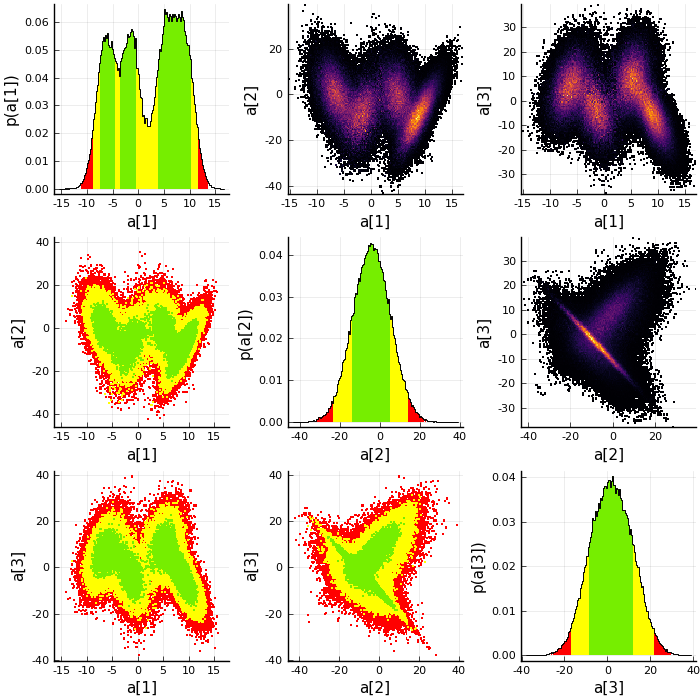

In [10]:
plot(samples_1, size=(700,700), upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

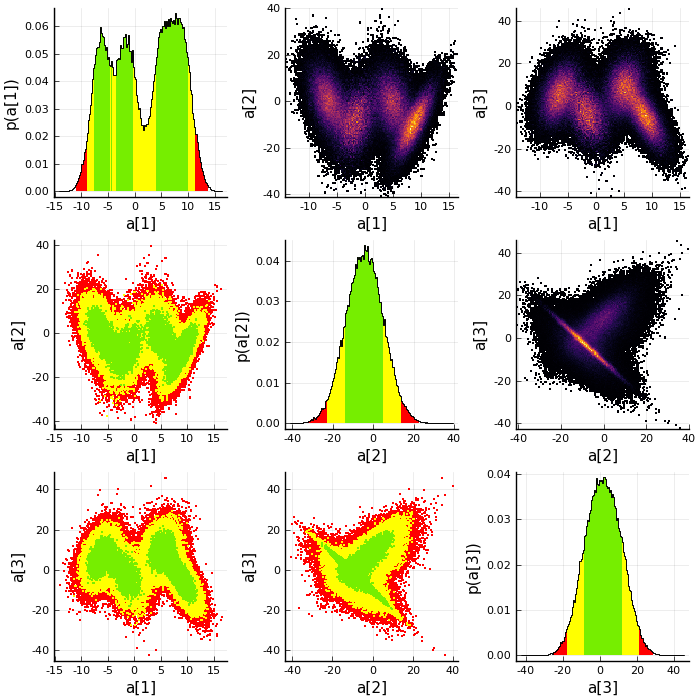

In [11]:
plot(samples_2, size=(700,700), upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

## 3. Detailed sampling summary

Run information:

In [12]:
columnnames(output_sp.info)

(:density_integral, :sampling_cpu_time, :integration_cpu_time, :sampling_wc, :integration_wc, :worker_id, :n_threads, :samples_ind, :sum_weights)

In [15]:
output_sp.info

Table with 9 columns and 5 rows:
     density_integral   sampling_cpu_time  integration_cpu_time  ⋯
   ┌──────────────────────────────────────────────────────────────
 1 │ 2.792e-7±4.1e-9    10.641             3.22737               ⋯
 2 │ 2.379e-7±2.9e-9    6.4209             0.647724              ⋯
 3 │ 1.511e-7±1.6e-9    5.02475            0.630824              ⋯
 4 │ 1.0387e-7±8.9e-10  6.10633            0.823122              ⋯
 5 │ 2.406e-7±3.1e-9    6.64887            0.56757               ⋯

In [16]:
posterior_integral = sum(output_sp.info.density_integral)

1.0126e-6 ± 6.2e-9

In [17]:
log(posterior_integral)

-13.803 ± 0.0061

In [18]:
total_cpu_time = sum(output_sp.info.sampling_cpu_time) + sum(output_sp.info.integration_cpu_time)

40.738484

In [19]:
total_wc_time = (output_sp.info.sampling_wc[end][end] - output_sp.info.sampling_wc[1][1])*1e-9

15.567

Partition tree: 

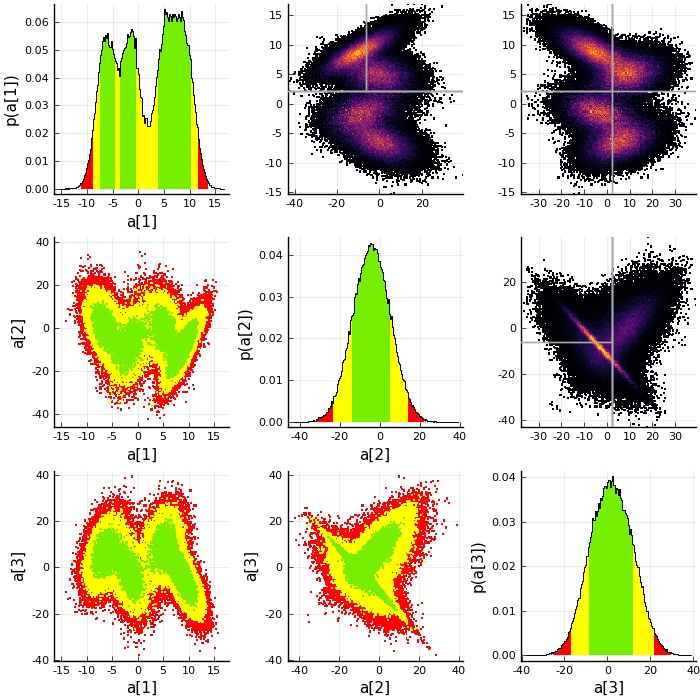

In [20]:
plot(samples_1, size=(700,700), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

Exploration samples: 

In [21]:
n_explorstion = length(output_sp.exp_samples)

3000

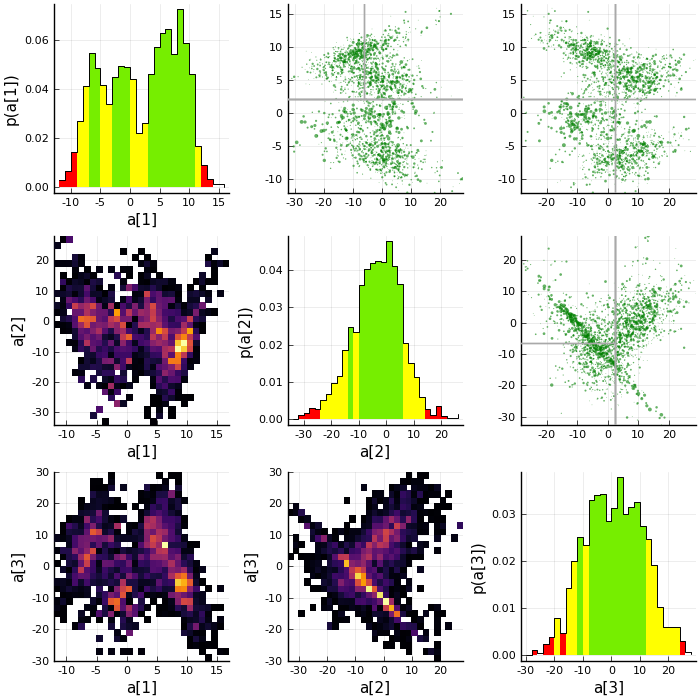

In [22]:
plot(output_sp.exp_samples, size=(700,700), 
    upper = Dict("seriestype"=>:scatter, "colors"=>:red, "partition_tree"=>output_sp.part_tree,), 
    lower = Dict("seriestype"=>:hist, "bins"=>30),
    diagonal = Dict("bins"=>30),)

## 4. Fine-grained control: Samplers, integrators, partitioner 

Subspace sampler can be any `BAT.AbstractSamplingAlgorithm` algorithm: 

In [23]:
sampler = MetropolisHastings() # AHMC()

burnin_1 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 400,
        max_nsteps_per_cycle = 400,
        max_time_per_cycle = 25,
        max_ncycles = 20
    )

sampling_kwargs = (burnin = burnin_1,);

The same with exploration sampler

In [24]:
# Sobol Sampler: 
# exploration_sampler = BAT.SobolSampler()
# exploration_kwargs = NamedTuple()
# n_exploration = (10^2, 40);

# MetropolisHastings: 
exploration_sampler = MetropolisHastings()
burnin_2 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 400,
        max_nsteps_per_cycle = 400,
        max_time_per_cycle = 25,
        max_ncycles = 5
    )
exploration_kwargs = (burnin = burnin_1,)
n_exploration = (10^2, 40);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [25]:
partitioner = KDTreePartitioning(
        partition_dims = [1,2,], # dimension indices that are considered for partition
        extend_bounds=false # "false" is appropriate for debugging, very fast tuning /convergence 
    );

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [26]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

Finally, `PartitionedSampling` can be defined using settings: 

In [27]:
algorithm = PartitionedSampling(
        sampler = sampler,
        exploration_sampler = exploration_sampler,
        partitioner = partitioner,
        integrator = integrator,
        exploration_kwargs = exploration_kwargs,
        sampling_kwargs = sampling_kwargs,
        n_exploration = n_exploration
    );

In [28]:
output_sp_ms = bat_sample(posterior, (n_samples, n_chains, 40), algorithm);

samples_3 = output_sp_ms.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:71
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 40 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 40 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 40 chains, 3 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info:

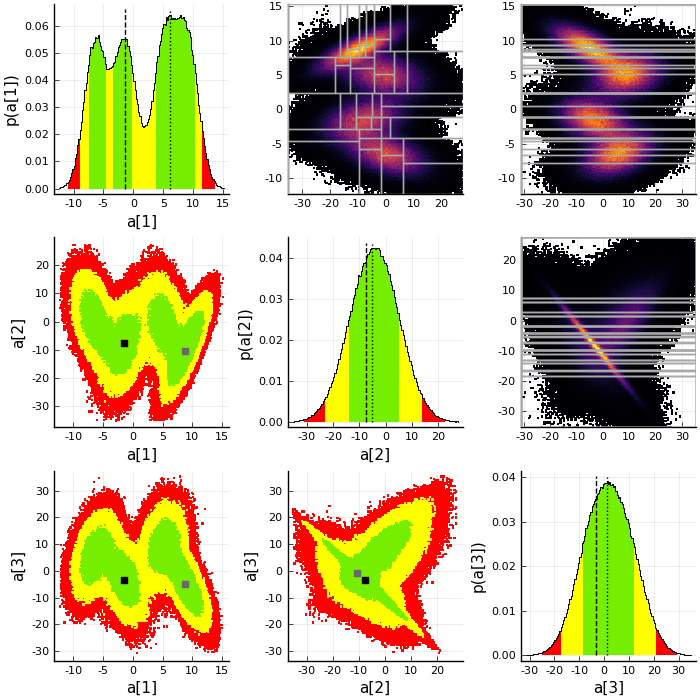

In [29]:
plot(samples_3, vsel=[1,2,3], size=(700,700), globalmode=true, localmode=true, 
    upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [30]:
posterior_integral = sum(output_sp_ms.info.density_integral)

9.972e-7 ± 1.5e-9

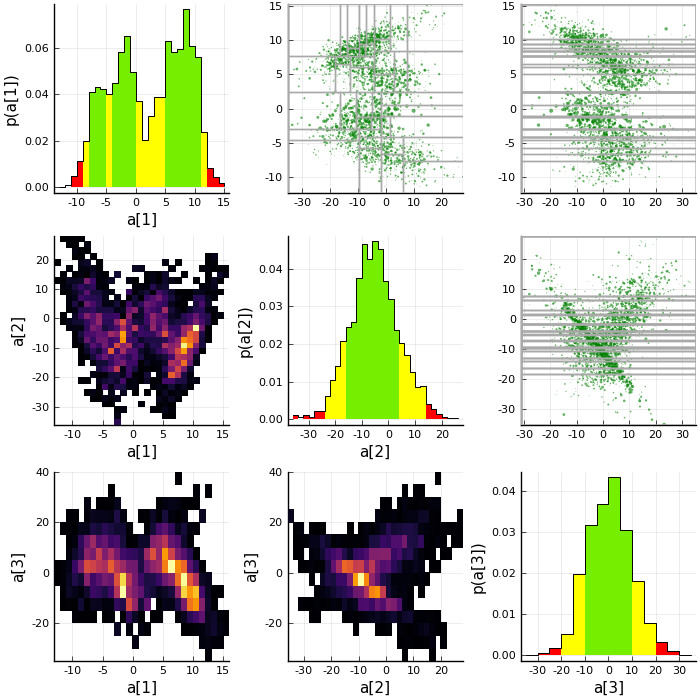

In [31]:
plot(output_sp_ms.exp_samples, size=(700,700), 
    upper = Dict("seriestype"=>:scatter, "partition_tree"=>output_sp_ms.part_tree,), 
    lower = Dict("seriestype"=>:hist, "bins"=>30),
    diagonal = Dict("bins"=>30),)